In [ ]:
#EEG
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('signals_data.csv')
df.sample(20)
# the values usually represent the electrical potentials recorded at each electrode. The units are typically microvolts (μV) or millivolts (mV)

In [ ]:
# len(df.columns.tolist())
# To list the columns names
df.columns.tolist()

Represent electrode locations in an EEG (electroencephalogram) data set. EEG is a recording of electrical activity along the scalp produced by the firing of neurons within the brain. Each column corresponds to the electrical activity recorded at a specific location on the scalp.

* Fp1, Fp2: Frontopolar (Frontoparietal) - frontal pole
* AF3, AF4: Anterior Frontal - frontal region
* F3, F4: Frontal - frontal region
* F7, F8: Frontotemporal - frontotemporal region
* FC5, FC6: Frontocentral - frontocentral region
* FC1, FC2: Frontal - frontal region
* C3, C4: Central - central region
* T7, T8: Temporal - temporal region
* CP5, CP6: Centroparietal - centroparietal region
* CP1, CP2: Parietal - parietal region
* P3, P4: Parietal - parietal region
* P7, P8: Parietooccipital - parietooccipital region
* PO3, PO4: Parietooccipital - parietooccipital region
* O1, O2: Occipital - occipital region
* Oz: Occipital midline - midline occipital region
* Pz: Parietal midline - midline parietal region
* Fz: Frontal midline - midline frontal region

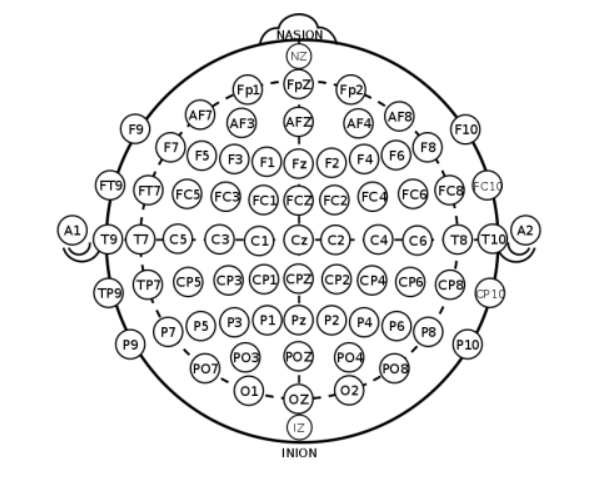

In [ ]:
df.isnull().sum()

In [ ]:
df.shape

In [ ]:
duplicate_rows = df[df.duplicated()]

# Print duplicate rows
print("Duplicate Rows:")
print(duplicate_rows)

# Remove duplicate rows
df = df.drop_duplicates()

# After removing duplicates, reset index
df.reset_index(drop=True, inplace=True)

In [ ]:
df

In [ ]:
# Drop the last column
# df = df.iloc[:, :-1]

In [ ]:
df.head()

In [ ]:
def make_plot(column):
    plt.figure(figsize=(10, 6))
    plt.plot(df[column], label='EEG Signal', color='blue', linewidth=1.5)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('EEG Signal Visualization')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

    plt.legend()
    plt.show()

make_plot('FP1')

In [ ]:
make_plot('P8')

In [ ]:
# df.shape
len(df)

In [ ]:
norm = df.loc[df["Label"]=="normal"]
undld = df.loc[df["Label"]=="underload"]
ovrld = df.loc[df["Label"]=="overload"]

In [ ]:
norm

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 5))
plt.title("Data Distribution", fontsize=16)
# plt.style.use('seaborn-darkgrid')

# Create the countplot with seaborn
ax = sns.countplot(x='Label', data=df, palette='viridis')

# Add exact count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height() + 5),
                ha='center', fontsize=10, color='black')

plt.xlabel("Load state", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['Label'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

In [ ]:
df.head()

In [ ]:
columns_to_drop = ['Label', 'encoded_labels']
dropped_columns_df = df[columns_to_drop]
df = df.drop(columns=columns_to_drop)

#Bandpass filtering

In [ ]:
#To perform bandpass filtering on each row of a DataFrame using a Butterworth filter
#Applying bandpass filtering to EEG data serves several purposes in the preprocessing pipeline:
# Frequency Band Selection
# Noise Reduction
# Improved Signal Quality
# Facilitate Further Analysis
# Enhance Signal-to-Noise Ratio
import numpy as np
from scipy.signal import butter, filtfilt
import pandas as pd

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

fs = 500
lowcut = 12.0
highcut = 35.0

# Apply the filter to each row
filtered_data = df.apply(lambda row: butter_bandpass_filter(row, lowcut, highcut, fs), axis=1)
filtered_df = pd.DataFrame(filtered_data.tolist(), columns=df.columns)

# A bandpass filter is a type of filter that allows signals within a certain frequency range, known as the passband, to pass through while blocking signals outside this range in the stopband.
# Bandpass filters are often employed in applications where only a specific range of frequencies needs to be extracted or preserved.

In [ ]:
def make_plot_pre_processed(column):
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df[column], label='EEG Signal', color='blue', linewidth=1.5)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('EEG Signal Visualization')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

    plt.legend()
    plt.show()

make_plot_pre_processed('T8')



 - `from scipy.signal import butter, filtfilt`: Imports functions from the SciPy library for signal processing, including the Butterworth filter.

**Butterworth Bandpass Filter Function:**
   - `butter_bandpass_filter(data, lowcut, highcut, fs, order=4)`: Defines a function that applies a Butterworth bandpass filter to a given data sequence.
      - `data`: Input data sequence (a row of the DataFrame in this case).
      - `lowcut`: Lower cutoff frequency of the bandpass filter.
      - `highcut`: Upper cutoff frequency of the bandpass filter.
      - `fs`: Sampling frequency of the data.
      - `order`: Order of the Butterworth filter (default is 4).

#Artifact removal
Independent Component Analysis (ICA) is a powerful technique commonly used for this purpose. ICA separates the mixed EEG signals into independent components, allowing you to identify and remove artifacts.

In [ ]:
from sklearn.decomposition import FastICA
import pandas as pd

filtered_df_transposed = df.T
n_components = len(filtered_df_transposed.columns)

# Apply ICA
ica = FastICA(n_components=n_components, random_state=42)
ica_result = ica.fit_transform(filtered_df_transposed.T)

# Create a DataFrame with the independent components
ica_df = pd.DataFrame(ica_result, columns=df.columns)

# Display the DataFrame after artifact removal
print(ica_df)

In [ ]:
# ica_df
plt.figure(figsize=(10, 6))
plt.plot(ica_df['FP1'], label='EEG Signal', color='blue', linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('EEG Signal Visualization')
plt.grid(True, linestyle='--', alpha=0.7)

plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.legend()
plt.show()

#Normalization:
Normalization: Scale the amplitude of EEG signals, if necessary, to ensure consistency across subjects or conditions.
Normalization is typically performed to scale the amplitude of EEG signals, ensuring consistency across subjects or conditions. A common approach is to normalize each electrode's activity by dividing it by its standard deviation.

In [ ]:
# Apply normalization
normalized_df = (ica_df - ica_df.mean(axis=0)) / ica_df.std(axis=0)

# it centers the data around zero and scales it to have a standard deviation of 1.
# Display the DataFrame after normalization
print(normalized_df)

In [ ]:
normalized_df.shape

In [ ]:
df = pd.concat([normalized_df, dropped_columns_df['encoded_labels']], axis=1)

In [ ]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1].values

In [ ]:
x.sample(5)

In [ ]:
def split_data_in_order(x, y, test_size):
    test_samples = int(len(x) * test_size)

    x_train = x[:-test_samples]
    x_test = x[-test_samples:]
    y_train = y[:-test_samples]
    y_test = y[-test_samples:]

    return x_train, x_test, y_train, y_test

In [ ]:
# x_train, x_test, y_train, y_test = split_data_in_order(x, y, test_size=0.3)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

In [ ]:
x_test.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
x_train.shape

Using ML algorithms

In [ ]:
!pip install joblib

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix
import joblib

saved_models = {}

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

for model_name, model in models.items():
    print(f"\n{model_name} Model:")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greens')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    classification_rep = classification_report(y_test, y_pred)
    print(f"{model_name} Classification Report:\n", classification_rep)

    filename = f"{model_name}_model.pkl"
    joblib.dump(model, filename)  # for scikit-learn version <= 0.23
    # dump(model, filename)  # for scikit-learn version >= 0.24
    saved_models[model_name] = filename

LSTM 

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
x_train.shape

In [ ]:
x_test[0]

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_train

In [ ]:
batch_size = 256
num_classes = 3
epochs = 5
input_shape=(x_train.shape[1], 1)

In [ ]:
print(input_shape)

In [ ]:
import keras

In [ ]:
from keras.regularizers import l2
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()

model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
model.add(Dropout(0.6))

model.add(LSTM(units = 256, return_sequences = True))
model.add(Dropout(0.6))

model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.6))

model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 32))
model.add(Dropout(0.4))

model.add(Dense(units = 16))
model.add(Activation('relu'))

model.add(Dense(units = num_classes))
model.add(Activation('softmax'))
model.compile(optimizer ="adam", loss =keras.losses.categorical_crossentropy,metrics=["accuracy"])
m = model.fit(x_train, y_train,epochs=3,batch_size=256,verbose=1,validation_data=(x_test, y_test))

In [ ]:
model.summary()

In [ ]:
model.save('LSTM.h5')

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
import matplotlib.pyplot as plt
print(m.history.keys())
# summarize history for accuracy
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(m.history['val_accuracy'])
plt.plot(m.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()